# 퍼셉트론 구현 - 텐서플로우 1

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.__version__

'1.15.0'

## 데이터
* XOR 연산을 위해 아래와 같은 데이터를 준비했음
* np.expand_dims는 차원을 하나 늘려주는 역할을 함
  * 인자로 axis에 정해준 차원을 하나 늘려줌

In [3]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

# (4,) 차원 데이터를 (4, 1)로 늘려줌
y = np.expand_dims(np.array([0, 1, 1, 0]), axis=-1)

In [4]:
print(X.shape)
print(y.shape)

(4, 2)
(4, 1)


## 구현 기본 구조
텐서플로우로 모델을 구현할 때, 아래 세 가지 요소를 가지고 만든다.
1. 데이터가 다닐 통로
2. 레이어 구조 정의
3. 목적식 (손실함수) 정의

### 1. 데이터가 다닐 통로 정의
  * 입력 데이터와 출력 데이터 모두 정의
  * 입력 데이터는 한 개에 2차원
  * 몇 개의 데이터가 들어갈지 모를 때는 shape에 None을 쓸 수 있음
  * 우리 데이터는 4줄이 들어가지만 일단 None이라고 하기

In [5]:
# 입력 데이터는 2차원
inputs = tf.placeholder(shape=(None, 2), dtype=tf.float32)
inputs

<tf.Tensor 'Placeholder:0' shape=(?, 2) dtype=float32>

In [6]:
# 최종 출력은 1차원
outputs = tf.placeholder(shape=(None, 1), dtype=tf.float32)
outputs

<tf.Tensor 'Placeholder_1:0' shape=(?, 1) dtype=float32>

### 2. 레이어 구조 정의
  * 입력 데이터가 2차원
  * 뉴런 3개에서 출력 되기로 해봄
  * 따라서 가중치에 해당하는 ```tf.Variable()```에 들어갈 차원 모양은 ```shape=(3, 2)```

In [7]:
# 입력 데이터 2차원, 출력 뉴런 3개이므로 2x3행렬
W0 = tf.Variable(tf.random_uniform((2, 3)))
# 바이어스도 추가해주자
b0 = tf.Variable(tf.ones((3)))
print(W0)
print(b0)

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(3,) dtype=float32_ref>


뉴런 출력 결과는 입력 데이터와 가중치의 행렬의 곱셈이다.

즉 None x 2 (입력 데이터) 행렬과 2 x 3 행렬의 곱셈 결과로 은닉층 뉴런이 만들어진다.

이 때, 행렬곱을 위해 ```tf.matmul()```을 쓴다.

```python
tf.matmul(
    a,
    b,
    transpose_a=False,
    transpose_b=False,
)
```
인자로 a, b 행렬을 주고, 역행렬을 만들지 말지는 transpose_a, transpose_b로 정해준다.


In [8]:
z0 = tf.matmul(inputs, W0) + b0
z0

<tf.Tensor 'add:0' shape=(?, 3) dtype=float32>

```python
tf.math.sigmoid(
    x,
    name=None
)
```
인자로 넣은 행렬의 요소별로(element-wise)로 아래 식과 같은 시그모이드 함수를 통과시킴
$$
{1 \over 1 + e^{-x}}
$$

In [9]:
# 활성함수로 시그모이드 함수 사용
z0 = tf.sigmoid(z0)
z0

<tf.Tensor 'Sigmoid:0' shape=(?, 3) dtype=float32>

In [10]:
# 입력 뉴런이 3개, 출력 데이터 1차원이므로 3x1 행렬
W1 = tf.Variable(tf.random_uniform((3, 1)))
# 바이어스도 추가
b1 = tf.Variable(tf.ones((1)))
print(W1)
print(b1)

<tf.Variable 'Variable_2:0' shape=(3, 1) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(1,) dtype=float32_ref>


In [11]:
z1 = tf.matmul(z0, W1) + b1
z1

<tf.Tensor 'add_1:0' shape=(?, 1) dtype=float32>

In [12]:
# 시그모이드 적용한 결과에 해당
z1 = tf.sigmoid(z1)
z1

<tf.Tensor 'Sigmoid_1:0' shape=(?, 1) dtype=float32>

### 3. 목적식 (손실함수) 정의
이 문제의 목적식은 아래와 같다.
$$
\mbox{minimize } \sum \bigg( target - outputs \bigg)^2
$$

데이터의 실제값 (target)과 모델이 예측한 결과(outputs)의 mean squared error 를 최소화하는 것이다.

target과 outputs의 차이 제곱을 먼저 아래와 같이 구한다.

In [13]:
loss = (outputs - z1) ** 2
loss

<tf.Tensor 'pow:0' shape=(?, 1) dtype=float32>

다음으로 $\sum$ 부분은 아래 함수를 쓴다.

```python
tf.reduce_mean(
    input_tensor,
    axis=None,
)
```
input_tensor로 넣은 텐서의 axis로 정한 차원의 평균을 구한다.

즉,

$$
{\sum_{\mbox{axis}}^N x_{ijk} \over N}
$$

과 같은 역할을 한다. axis 인자가 차원 $i, j, k$ 중 어떤 걸 쓸지 정하는 역할을 한다. None으로 그대로 둘 경우 모든 차원의 평균을 구한다.

In [14]:
loss = tf.reduce_mean(loss)
loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

다음으로 minimize 를 구현하기에 앞서 backpropagation을 수행하기 위한 미분기(optimizer)를 만든다.

이 미분기에 목적식의 minimize에 해당하는 곳에 들어갈 loss를 넣어준다.

In [15]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=.2).minimize(loss)
optimizer

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Operation 'GradientDescent' type=NoOp>

### 모델 학습

In [16]:
# 세션을 생성하고, tf.Variable()에 들어갈 값들을 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [17]:
# 학습하는 동안 로스(loss, 손실) 변화가 어떻게 되는지 관찰하기 위해 리스트에 저장
loss_list = list()

In [18]:
# 총 학습 횟수
EPOCHS = 30000

for e in range(EPOCHS):
    # 데이터 4줄 중에서 한 개를 임의로 선택
    idx = np.random.randint(4)
    # minimize하도록 한 텐서 연산을 실행
    # 이 때, 입력 데이터(inputs)와 출력 데이터(outputs)에 X와 y값을 넣어줌
    # tf.placeholer()에서 shape의 0번째 차원을 None으로 주었기 때문에 한 번에 하나씩 데이터를 넣거나
    # 그 이상 몇개씩 넣어도 됨
    sess.run(optimizer, feed_dict={inputs:X[idx:idx+1], outputs: y[idx:idx+1]})
    # loss 텐서 연산을 실행해서 (이때는 데이터 4줄을 한 번에 다 넣었음) 리스트에 하나씩 저장
    loss_list.append(sess.run(loss, {inputs:X, outputs:y}))

모델의 학습이 잘 이루어지느냐 마느냐는 로스가 0으로 수렴해가느냐 아니냐와 같음

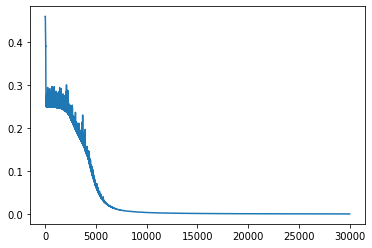

In [19]:
# 만 번 학습하는 동안 로스 변화를 그래프로 그려보기
plt.plot(loss_list)
plt.show()

## 모델 평가

In [20]:
# XOR 연산 결과로 0, 1, 1, 0에 가깝게 예측 함
y_pred = sess.run(z1, feed_dict={inputs:X})

In [21]:
for y_real, y_ in zip(y, y_pred):
    print(f"실제: {y_real[0]}, 예측: {y_[0]:.1f}")

실제: 0, 예측: 0.0
실제: 1, 예측: 1.0
실제: 1, 예측: 1.0
실제: 0, 예측: 0.0


In [22]:
# 세션 닫기
sess.close()